## Encoder Linear v.s. Nonlinear dynamics

In [1]:
# packages
import torch
import pandas as pd
from pygsig.datasets.subduction import SubductionZone
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
from ts2vec import ts2vec

In [15]:
# Download data
poly_path='datasets/subduction/polygon.geojson' # region of interest
rast_path='datasets/subduction/interface.grd' # interface data
data_path='datasets/subduction/data.geojson' # earthquake data
site_path='datasets/subduction/location.geojson' # site data
label_path='datasets/subduction/nonlinear.json'

dataset = SubductionZone(poly_path='datasets/subduction/polygon.geojson',
                         rast_path='datasets/subduction/interface.grd',
                         label_path='datasets/subduction/nonlinear.json',
                         data_path='datasets/subduction/data.geojson',
                         site_path='datasets/subduction/location.geojson',
                         start_date=pd.Timestamp('2005-01-01 11:59:00+0000', tz='UTC'),
                         end_date=pd.Timestamp('2023-12-31 11:59:00+0000', tz='UTC'),
                         download=False)

100%|██████████| 86/86 [04:48<00:00,  3.36s/it]


In [16]:
from torch_geometric_temporal.signal.train_test_split import temporal_signal_split

seq = dataset.get_graph(task='classification',k=4)
encoder_seq, gnn_seq = temporal_signal_split(seq,train_ratio=0.5)

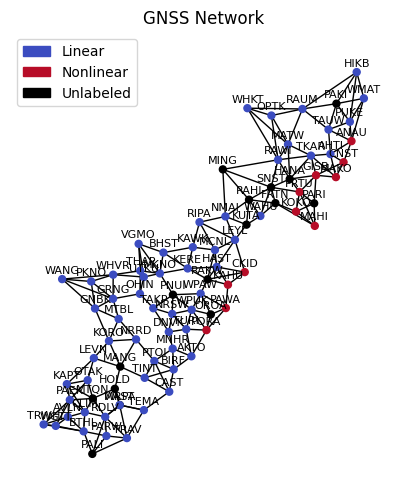

In [17]:
import matplotlib.pyplot as plt

blue = '#3b4cc0'
red = '#b70d28'

G = nx.Graph()
G.add_nodes_from(range(seq.num_nodes))
G.add_edges_from(seq[0].edge_index.T.tolist())

pos = {node: position.numpy() for node, position in enumerate(seq[0].pos)}
depth = {node: measurement.item() for node, measurement in enumerate(seq[0].y)}
vector_depth = np.array([depth[i] for i in range(len(depth))])

# Define color map based on labels
color_map = {0: blue, -1: 'black', 1: red}
node_colors = [color_map[depth[node]] for node in G.nodes]

plt.figure(figsize=(5, 6))
nx.draw_networkx_nodes(G, pos=pos, node_size=25, node_color=node_colors)
nx.draw_networkx_edges(G, pos=pos)
nx.draw_networkx_labels(G, pos={k: (v[0], v[1] + 10000) for k, v in pos.items()}, labels={i: dataset.siteIDs[i] for i in range(len(dataset.siteIDs))}, font_size=8)
plt.title('GNSS Network')
plt.axis('off')

# Create legend
import matplotlib.patches as mpatches
linear_patch = mpatches.Patch(color=blue, label='Linear')
nonlinear_patch = mpatches.Patch(color=red, label='Nonlinear')
unlabeled_patch = mpatches.Patch(color='black', label='Unlabeled')
plt.legend(handles=[linear_patch, nonlinear_patch, unlabeled_patch])
plt.show()


# TS2Vec Encoder

In [18]:
from ts2vec.ts2vec import TS2Vec
import signatory

X_train = torch.stack([snapshot.x for snapshot in encoder_seq]).transpose(0, 1).numpy()

encoder = TS2Vec(
    input_dims=3,
    device='cpu',
    hidden_dims=64,
    output_dims=128,
    batch_size=1,
)


loss_log = encoder.fit(
    X_train,
    verbose=True,
)

torch.save(encoder,'encoders/geonet/TS2Vec.pt')

Epoch #0: loss=2558.670591310013
Epoch #1: loss=201.92865391664728
Epoch #2: loss=99.04904145972674
Epoch #3: loss=66.13092270562815
Epoch #4: loss=53.28929144837136
Epoch #5: loss=42.46255952812905


In [19]:
import torch_geometric.transforms as T
from torch_geometric.data import Data
from pygsig.graph import StaticGraphTemporalSignal

class TS2VecFeatures(T.BaseTransform):
    def __init__(self, encoder,normalize=False):
        super().__init__()
        self.encoder = encoder
        self.normalize = normalize

    def forward(self, dataset):
        X = torch.stack([snapshot.x for snapshot in dataset]).transpose(0, 1).numpy()
        x = torch.tensor(encoder.encode(X, encoding_window='full_series'))
        y = dataset[-1].y
        pos = dataset[-1].pos

        # Normalize if required
        if self.normalize:
            std_x = torch.std(x, dim=0)
            mean_x = torch.mean(x, dim=0)
            x = (x - mean_x) / std_x

        # Create the static graph dataset with transformed features
        dataset_static = Data(x=x, y=y, edge_index=dataset.edge_index, edge_weight=dataset.edge_weight, pos=pos)
        return dataset_static

Model: GCNClassification
Number of parameters: 33153


100%|██████████| 50/50 [00:23<00:00,  2.11it/s]

Accuracy: 0.9277 ± 0.0511, F1: 0.7860 ± 0.1592, Precision: 0.7967 ± 0.2268, Recall: 0.8467 ± 0.2104


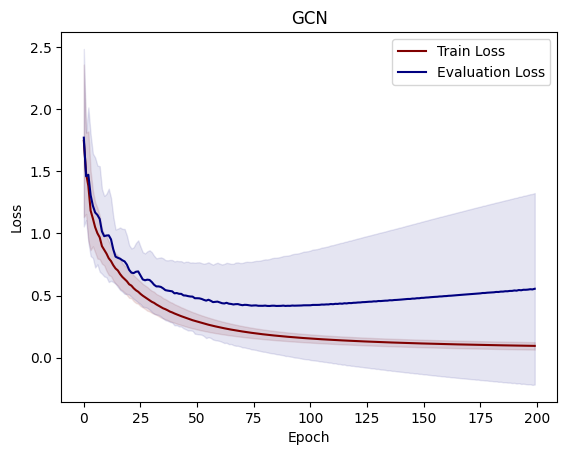

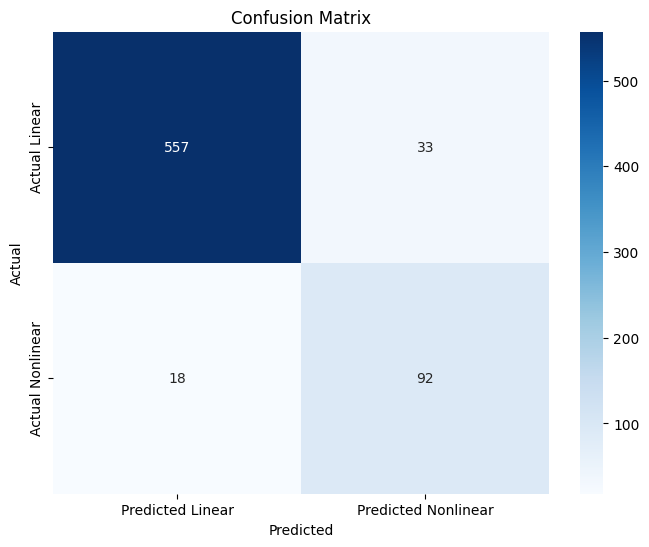

In [20]:
import torch
import torch.nn as nn
from sklearn.metrics import mean_squared_error, mean_absolute_error, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import torch_geometric.transforms as T
from sklearn.preprocessing import StandardScaler

# Import custom modules
import pygsig.graph 
import pygsig.models
import pygsig.signature
from pygsig.models import GCNClassification,MLPClassification
from pygsig.graph import split_nodes
from pygsig.signature import SignatureFeatures

# encoder
encoder = torch.load('encoders/geonet/TS2Vec.pt')
ts2vec = TS2VecFeatures(encoder,normalize=False)

# Apply signature transformation to the sequential data
data = ts2vec(gnn_seq)

# Set up parameters
num_nodes = data.num_nodes
num_splits = 5
num_trials = 10
num_epochs = 200
learning_rate = 1e-3
lasso = 0
num_hidden = data.num_node_features
print_during_training = False

# Create class weights for handling imbalance
positive_class_count = (data.y == 1).sum().item()
negative_class_count = (data.y == 0).sum().item()
class_weights = torch.tensor([negative_class_count / positive_class_count], dtype=torch.float)

# Initialize models
models = []
models.append(GCNClassification(num_channels=[data.num_node_features, num_hidden, num_hidden, 1]))

model_names = ['GCN']

accuracy_models = []
predictions_models = []

# Create a mask for valid labels (ignoring -1)
label_mask = data.y != -1

# Criterion for binary classification with BCEWithLogitsLoss
criterion = nn.BCEWithLogitsLoss(pos_weight=class_weights)

# Initialize arrays for metrics
accuracy_models = []
confusion_models = []
all_predictions = []

for model_number, model in enumerate(models):
    print(f'Model: {model._get_name()}')
    print(f"Number of parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad)}")
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=lasso)
    
    # Initialize arrays to store losses
    train_losses = np.zeros([num_splits, num_trials, num_epochs])
    eval_losses = np.zeros([num_splits, num_trials, num_epochs])
    
    accuracy = np.zeros([num_splits, num_trials])
    f1 = np.zeros([num_splits, num_trials])
    precision = np.zeros([num_splits, num_trials])
    recall = np.zeros([num_splits, num_trials])
    confusion_matrices = np.zeros([num_splits, num_trials, 2, 2])
    
    with tqdm(total=num_splits * num_trials, disable=print_during_training) as pbar:
        splits = split_nodes(num_nodes, num_splits, test_ratio=1.0, seed=31) # no validation
        
        for split in range(num_splits):
            train_indices, eval_indices, test_indices = splits[split]
            
            # Create masks for training, evaluation, and testing
            train_mask = torch.zeros(num_nodes, dtype=torch.bool)
            eval_mask = torch.zeros(num_nodes, dtype=torch.bool)
            test_mask = torch.zeros(num_nodes, dtype=torch.bool)
            
            train_mask[train_indices] = True
            eval_mask[eval_indices] = True
            test_mask[test_indices] = True
            
            # Apply label mask to exclude -1 values
            valid_train_mask = train_mask & label_mask
            valid_eval_mask = eval_mask & label_mask
            valid_test_mask = test_mask & label_mask

            for trial in range(num_trials):
                model.reset_parameters()
                for epoch in range(num_epochs):
                    # Training phase
                    model.train()
                    optimizer.zero_grad()
                    out = model(data.x, data.edge_index, data.edge_attr)
                    
                    # Apply valid train mask to loss computation
                    train_loss = criterion(out[valid_train_mask], data.y[valid_train_mask].unsqueeze(1))
                    train_loss.backward()
                    optimizer.step()

                    # Evaluation phase
                    model.eval()
                    with torch.no_grad():
                        eval_loss = criterion(out[valid_eval_mask], data.y[valid_eval_mask].unsqueeze(1))
                        test_loss = criterion(out[valid_test_mask], data.y[valid_test_mask].unsqueeze(1))
                        train_losses[split, trial, epoch] = train_loss.item()
                        eval_losses[split, trial, epoch] = test_loss.item()
                    
                    if epoch % 10 == 0 and print_during_training:
                        print(f'Split {split}, Trial {trial}, Epoch {epoch}, Train Loss: {train_loss.item():.4f}, Eval Loss: {eval_loss.item():.4f}')
                
                pbar.update(1)

                # Evaluation on test set with valid labels
                with torch.no_grad():
                    out = model(data.x, data.edge_index, data.edge_attr)
                    y_true = data.y.unsqueeze(1)
                    predictions = (out > 0.5).float()  # Binary predictions
                    
                    # Compute performance metrics
                    confusion_matrices[split, trial] = confusion_matrix(y_true[valid_test_mask].numpy(), predictions[valid_test_mask].numpy())
                    accuracy[split, trial] = accuracy_score(y_true[valid_test_mask].numpy(), predictions[valid_test_mask].numpy())
                    f1[split, trial] = f1_score(y_true[valid_test_mask].numpy(), predictions[valid_test_mask].numpy(), zero_division=0)
                    precision[split, trial] = precision_score(y_true[valid_test_mask].numpy(), predictions[valid_test_mask].numpy(),zero_division=0)
                    recall[split, trial] = recall_score(y_true[valid_test_mask].numpy(), predictions[valid_test_mask].numpy(), zero_division=0)
                    all_predictions.append(predictions.squeeze().numpy())

                    

    # Print results for the model
    print(f'Accuracy: {np.mean(accuracy):.4f} ± {np.std(accuracy):.4f}, F1: {np.mean(f1):.4f} ± {np.std(f1):.4f}, Precision: {np.mean(precision):.4f} ± {np.std(precision):.4f}, Recall: {np.mean(recall):.4f} ± {np.std(recall):.4f}')
    

    confusion_models.append(confusion_matrices)
    accuracy_models.append(accuracy)

    # Plotting the training and evaluation loss
    avg_train_losses = np.mean(train_losses, axis=(0, 1))
    avg_eval_losses = np.mean(eval_losses, axis=(0, 1))
    std_train_losses = np.std(train_losses, axis=(0, 1))
    std_eval_losses = np.std(eval_losses, axis=(0, 1))
    
    plt.figure()
    plt.plot(avg_train_losses, label='Train Loss', color='maroon')
    plt.plot(avg_eval_losses, label='Evaluation Loss', color='navy')
    plt.fill_between(range(num_epochs), avg_train_losses - std_train_losses, avg_train_losses + std_train_losses, alpha=0.1, color='maroon')
    plt.fill_between(range(num_epochs), avg_eval_losses - std_eval_losses, avg_eval_losses + std_eval_losses, alpha=0.1, color='navy')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(f'{model_names[model_number]}')
    plt.legend()
    plt.show()


    # Plot confusion matrices
    cm = confusion_matrices.sum(axis=(0, 1))
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt=".0f", cmap="Blues", xticklabels=['Predicted Linear', 'Predicted Nonlinear'], yticklabels=['Actual Linear', 'Actual Nonlinear'])
    plt.title(f'Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

In [21]:
ts2vec_mean_prediction = np.mean(np.stack(all_predictions), axis=0)

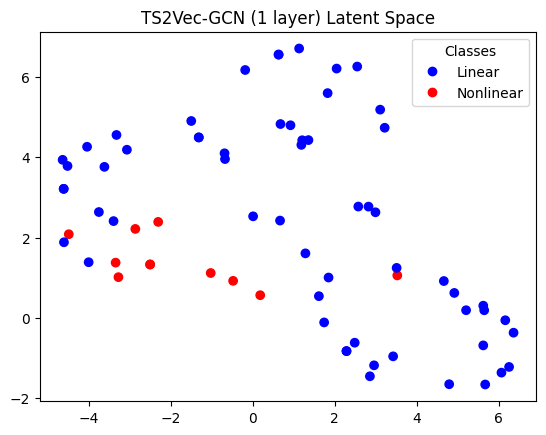

In [26]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import random


latent_variables = model.conv[0](data.x, data.edge_index)

tsne = TSNE(n_components=2, perplexity=30, random_state=30)
X_embedded = tsne.fit_transform(latent_variables.detach().numpy())

label_mask = data.y != -1

plt.figure()
scatter = plt.scatter(X_embedded[label_mask, 0], X_embedded[label_mask, 1], c=data.y[label_mask].numpy(), cmap='bwr')
plt.legend(handles=scatter.legend_elements()[0], labels=['Linear', 'Nonlinear'], title="Classes")
plt.title('TS2Vec-GCN (1 layer) Latent Space')
plt.show()

## Path signature encoder

Model: GCNClassification
Number of parameters: 16836


100%|██████████| 50/50 [00:19<00:00,  2.62it/s]

Accuracy: 0.9420 ± 0.0506, F1: 0.7893 ± 0.1914, Precision: 0.8933 ± 0.2021, Recall: 0.7333 ± 0.2261


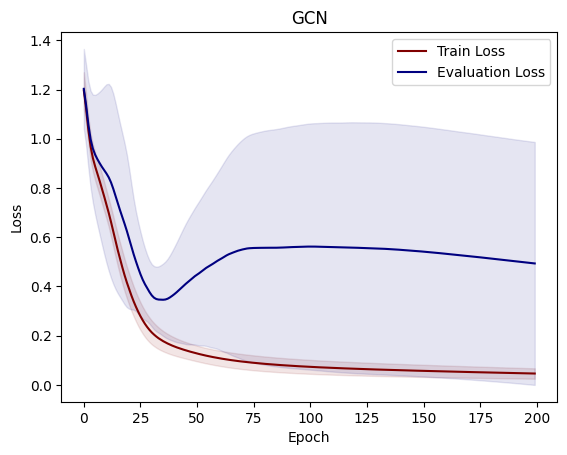

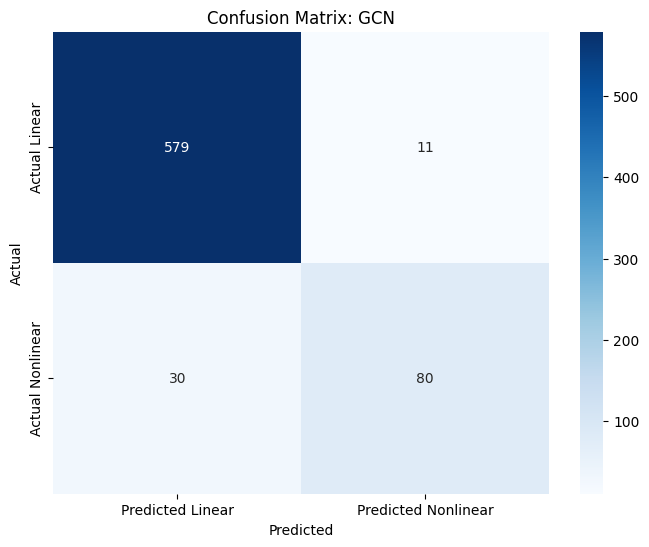

In [40]:
import torch
import torch.nn as nn
from sklearn.metrics import mean_squared_error, mean_absolute_error, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import torch_geometric.transforms as T
from sklearn.preprocessing import StandardScaler

# Import custom modules
import pygsig.graph 
import pygsig.models
import pygsig.signature
from pygsig.models import GCNClassification,MLPClassification
from pygsig.graph import split_nodes
from pygsig.signature import SignatureFeatures

import importlib
# Reload modules if needed
importlib.reload(pygsig.models)
importlib.reload(pygsig.signature)
importlib.reload(pygsig.graph)

# Set signature depth for the transformation
signature_depth = 3
signature_transform = SignatureFeatures(sig_depth=signature_depth, normalize=True, log_signature=True, time_augment=False, lead_lag=True)

# Apply signature transformation to the sequential data
data = signature_transform(seq)

# Set up parameters
num_nodes = data.num_nodes
num_splits = 5
num_trials = 10
num_epochs = 200
learning_rate = 1e-3
lasso = 0
num_hidden = data.num_node_features
print_during_training = False

# Create class weights for handling imbalance
positive_class_count = (data.y == 1).sum().item()
negative_class_count = (data.y == 0).sum().item()
class_weights = torch.tensor([negative_class_count / positive_class_count], dtype=torch.float)

# Initialize models
models = []
models.append(GCNClassification(num_channels=[data.num_node_features, num_hidden, num_hidden, 1]))

model_names = ['GCN']

accuracy_models = []
predictions_models = []
all_predicitons = []

# Create a mask for valid labels (ignoring -1)
label_mask = data.y != -1

# Criterion for binary classification with BCEWithLogitsLoss
criterion = nn.BCEWithLogitsLoss(pos_weight=class_weights)

for model_number, model in enumerate(models):
    print(f'Model: {model._get_name()}')
    print(f"Number of parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad)}")
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=lasso)
    
    # Initialize arrays to store losses
    train_losses = np.zeros([num_splits, num_trials, num_epochs])
    eval_losses = np.zeros([num_splits, num_trials, num_epochs])
    
    accuracy = np.zeros([num_splits, num_trials])
    f1 = np.zeros([num_splits, num_trials])
    precision = np.zeros([num_splits, num_trials])
    recall = np.zeros([num_splits, num_trials])
    confusion_matrices = np.zeros([num_splits, num_trials, 2, 2])
    
    with tqdm(total=num_splits * num_trials, disable=print_during_training) as pbar:
        splits = split_nodes(num_nodes, num_splits, test_ratio=1.0, seed=31) # no validation
        
        for split in range(num_splits):
            train_indices, eval_indices, test_indices = splits[split]
            
            # Create masks for training, evaluation, and testing
            train_mask = torch.zeros(num_nodes, dtype=torch.bool)
            eval_mask = torch.zeros(num_nodes, dtype=torch.bool)
            test_mask = torch.zeros(num_nodes, dtype=torch.bool)
            
            train_mask[train_indices] = True
            eval_mask[eval_indices] = True
            test_mask[test_indices] = True
            
            # Apply label mask to exclude -1 values
            valid_train_mask = train_mask & label_mask
            valid_eval_mask = eval_mask & label_mask
            valid_test_mask = test_mask & label_mask

            for trial in range(num_trials):
                model.reset_parameters()
                for epoch in range(num_epochs):
                    # Training phase
                    model.train()
                    optimizer.zero_grad()
                    out = model(data.x, data.edge_index, data.edge_attr)
                    
                    # Apply valid train mask to loss computation
                    train_loss = criterion(out[valid_train_mask], data.y[valid_train_mask].unsqueeze(1))
                    train_loss.backward()
                    optimizer.step()

                    # Evaluation phase
                    model.eval()
                    with torch.no_grad():
                        eval_loss = criterion(out[valid_eval_mask], data.y[valid_eval_mask].unsqueeze(1))
                        test_loss = criterion(out[valid_test_mask], data.y[valid_test_mask].unsqueeze(1))
                        train_losses[split, trial, epoch] = train_loss.item()
                        eval_losses[split, trial, epoch] = test_loss.item()
                    
                    if epoch % 10 == 0 and print_during_training:
                        print(f'Split {split}, Trial {trial}, Epoch {epoch}, Train Loss: {train_loss.item():.4f}, Eval Loss: {eval_loss.item():.4f}')
                
                pbar.update(1)

                # Evaluation on test set with valid labels
                with torch.no_grad():
                    out = model(data.x, data.edge_index, data.edge_attr)
                    y_true = data.y.unsqueeze(1)
                    predictions = (out > 0.5).float()  # Binary predictions
                    
                    # Compute performance metrics
                    confusion_matrices[split, trial] = confusion_matrix(y_true[valid_test_mask].numpy(), predictions[valid_test_mask].numpy())
                    accuracy[split, trial] = accuracy_score(y_true[valid_test_mask].numpy(), predictions[valid_test_mask].numpy())
                    f1[split, trial] = f1_score(y_true[valid_test_mask].numpy(), predictions[valid_test_mask].numpy(), zero_division=0)
                    precision[split, trial] = precision_score(y_true[valid_test_mask].numpy(), predictions[valid_test_mask].numpy(),zero_division=0)
                    recall[split, trial] = recall_score(y_true[valid_test_mask].numpy(), predictions[valid_test_mask].numpy(), zero_division=0)
                    all_predictions.append(predictions.squeeze().numpy())


                    

    # Print results for the model
    print(f'Accuracy: {np.mean(accuracy):.4f} ± {np.std(accuracy):.4f}, F1: {np.mean(f1):.4f} ± {np.std(f1):.4f}, Precision: {np.mean(precision):.4f} ± {np.std(precision):.4f}, Recall: {np.mean(recall):.4f} ± {np.std(recall):.4f}')
    

    confusion_models.append(confusion_matrices)
    accuracy_models.append(accuracy)

    # Plotting the training and evaluation loss
    avg_train_losses = np.mean(train_losses, axis=(0, 1))
    avg_eval_losses = np.mean(eval_losses, axis=(0, 1))
    std_train_losses = np.std(train_losses, axis=(0, 1))
    std_eval_losses = np.std(eval_losses, axis=(0, 1))
    
    plt.figure()
    plt.plot(avg_train_losses, label='Train Loss', color='maroon')
    plt.plot(avg_eval_losses, label='Evaluation Loss', color='navy')
    plt.fill_between(range(num_epochs), avg_train_losses - std_train_losses, avg_train_losses + std_train_losses, alpha=0.1, color='maroon')
    plt.fill_between(range(num_epochs), avg_eval_losses - std_eval_losses, avg_eval_losses + std_eval_losses, alpha=0.1, color='navy')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(f'{model_names[model_number]}')
    plt.legend()
    plt.show()


    # Plot confusion matrices
    cm = np.sum(confusion_matrices, axis=(0, 1))
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt=".0f", cmap="Blues", xticklabels=['Predicted Linear', 'Predicted Nonlinear'], yticklabels=['Actual Linear', 'Actual Nonlinear'])
    plt.title(f'Confusion Matrix: {model_names[model_number]}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

In [31]:
sig_mean_prediction = np.mean(np.stack(all_predictions), axis=0)

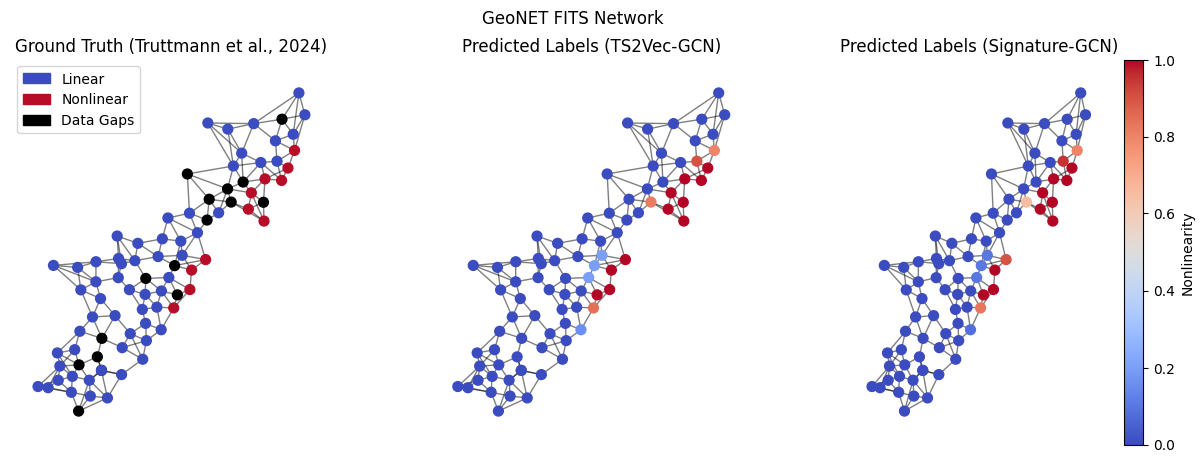

In [41]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# First plot: Mean Prediction
G = nx.Graph()
G.add_nodes_from(range(seq.num_nodes))
G.add_edges_from(seq[0].edge_index.T.tolist())

pos = {node: position.numpy() for node, position in enumerate(seq[0].pos)}
depth = {node: measurement.item() for node, measurement in enumerate(seq[0].y)}
vector_depth = np.array([depth[i] for i in range(len(depth))])

# Define color map based on mean predictions
cmap = plt.get_cmap('coolwarm')
node_colors = [cmap(ts2vec_mean_prediction[node]) for node in G.nodes]

axes[1].set_title('Predicted Labels (TS2Vec-GCN)')
nx.draw_networkx_nodes(G, pos=pos, node_size=50, node_color=node_colors, ax=axes[1])
nx.draw_networkx_edges(G, pos=pos, ax=axes[1], alpha=0.5)
# nx.draw_networkx_labels(G, pos={k: (v[0], v[1] + 10000) for k, v in pos.items()}, labels={i: siteIDs[i] for i in range(len(siteIDs))}, font_size=8, ax=axes[1])
axes[1].axis('off')

# Define color map based on mean predictions
cmap = plt.get_cmap('coolwarm')
node_colors = [cmap(sig_mean_prediction[node]) for node in G.nodes]

axes[2].set_title('Predicted Labels (Signature-GCN)')
nx.draw_networkx_nodes(G, pos=pos, node_size=50, node_color=node_colors, ax=axes[2])
nx.draw_networkx_edges(G, pos=pos, ax=axes[2], alpha=0.5)
# nx.draw_networkx_labels(G, pos={k: (v[0], v[1] + 10000) for k, v in pos.items()}, labels={i: siteIDs[i] for i in range(len(siteIDs))}, font_size=8, ax=axes[1])
axes[2].axis('off')

# Create color bar
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=0, vmax=1))
sm.set_array([])
fig.colorbar(sm, label='Nonlinearity', ax=axes[2])

# Second plot: Labels
# Define color map based on labels
color_map = {0: cmap(0), -1: 'black', 1: cmap(0.99)}
node_colors = [color_map[depth[node]] for node in G.nodes]

axes[0].set_title('Ground Truth (Truttmann et al., 2024)')
nx.draw_networkx_nodes(G, pos=pos, node_size=50, node_color=node_colors, ax=axes[0])
nx.draw_networkx_edges(G, pos=pos, ax=axes[0], alpha=0.5)
# nx.draw_networkx_labels(G, pos={k: (v[0], v[1] + 10000) for k, v in pos.items()}, labels={i: siteIDs[i] for i in range(len(siteIDs))}, font_size=6, ax=axes[0])
axes[0].axis('off')

# Create legend
linear_patch = mpatches.Patch(color=cmap(0), label='Linear')
nonlinear_patch = mpatches.Patch(color=cmap(0.99), label='Nonlinear')
unlabeled_patch = mpatches.Patch(color='black', label='Data Gaps')
axes[0].legend(handles=[linear_patch, nonlinear_patch, unlabeled_patch])

# Adjust space between figures
plt.subplots_adjust(wspace=0.3)

# Title
plt.suptitle('GeoNET FITS Network')
plt.show()


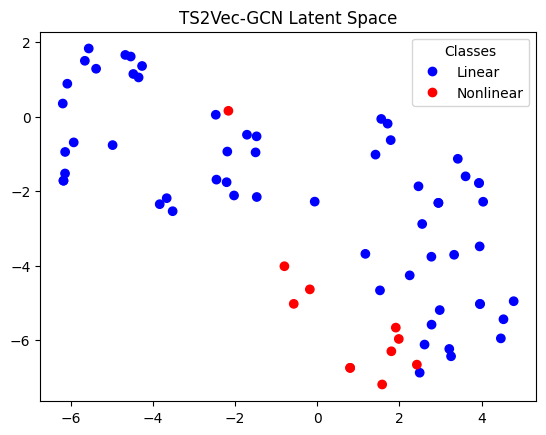

In [42]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import random


latent_variables = model.conv[0](data.x, data.edge_index)

tsne = TSNE(n_components=2, perplexity=30, random_state=30)
X_embedded = tsne.fit_transform(latent_variables.detach().numpy())

label_mask = data.y != -1

plt.figure()
scatter = plt.scatter(X_embedded[label_mask, 0], X_embedded[label_mask, 1], c=data.y[label_mask].numpy(), cmap='bwr')
plt.legend(handles=scatter.legend_elements()[0], labels=['Linear', 'Nonlinear'], title="Classes")
plt.title('TS2Vec-GCN Latent Space')
plt.show()